<a href="https://colab.research.google.com/github/ngohienduong/WQU-Econ/blob/main/W5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MScFE 610 Econometrics (C22-S1) - Groupwork Assignment Submission 2 M5

In [10]:
!pip install yfinance


### Impoting required libraries

In [11]:
import warnings
from IPython.display import Image
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib import rcParams
import statsmodels.api as sm
import datetime as dt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [12]:
warnings.filterwarnings('ignore')
%matplotlib inline
rcParams['figure.figsize'] = 20,10

### Step 0: Selecting a data set

For gold ETF, we choose SPDR Gold Trust (GLD) and for non-US equity ETF, we choose: iShares MSCI Emerging Markets ETF (EEM). We also pull data for Grayscale Bitcoin Trust (GBTC).

### Step 1: Data Importing

We consider three time points for splitting the pulled data:

In [13]:
Apr20 = dt.datetime(2020,4,1)
Jul20 = dt.datetime(2020,7,1)
Oct20 = dt.datetime(2020,10,1)
Jan21 = dt.datetime(2021,1,1)

#### Gold ETF (GLD):

In [14]:
GLD = yf.download('GLD',start = Apr20, end = Jan21,  progress = False)
GLD[Apr20:Jan21].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-01,148.199997,150.080002,147.850006,149.449997,149.449997,11827400
2020-04-02,151.199997,152.500000,150.699997,151.899994,151.899994,9188300
2020-04-03,152.229996,153.089996,151.660004,152.649994,152.649994,8469100
2020-04-06,154.160004,157.220001,153.960007,156.880005,156.880005,14739300
2020-04-07,155.330002,156.139999,154.380005,156.039993,156.039993,9195400


#### Emerging Markets ETF (EEM):

In [15]:
EEM = yf.download('EEM', start = Apr20, end = Jan21, progress = False)
EEM[Apr20:Jan21].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-01,33.099998,33.330002,32.619999,32.669998,31.540218,65580600
2020-04-02,33.290001,33.939999,33.200001,33.770000,32.602184,55784000
2020-04-03,33.689999,33.860001,32.950001,33.130001,31.984318,68672500
2020-04-06,34.439999,34.950001,34.299999,34.939999,33.731720,82394800
2020-04-07,36.090000,36.119999,35.049999,35.119999,33.905502,74322600


#### Bitcoin (BTC):

In [16]:
GBTC = yf.download('GBTC', start = Apr20, end = Jan21, progress = False)
GBTC[Apr20:Jan21].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-01,6.800,6.90,6.41,6.495,6.495,4274800
2020-04-02,7.000,7.87,6.98,7.720,7.720,7980600
2020-04-03,7.940,7.94,7.25,7.480,7.480,3059800
2020-04-06,7.824,8.06,7.71,7.950,7.950,4910400
2020-04-07,8.070,8.15,7.61,7.660,7.660,3469900


#### Integrating the data

In [17]:
data = pd.DataFrame({'EEM':EEM['Adj Close'], 'GLD':GLD['Adj Close'], 'GBTC':GBTC['Adj Close']})
data[Apr20:Jan21].head()

,EEM,GLD,GBTC
Date,,,
2020-04-01,31.540218,149.449997,6.495
2020-04-02,32.602184,151.899994,7.720
2020-04-03,31.984318,152.649994,7.480
2020-04-06,33.731720,156.880005,7.950
2020-04-07,33.905502,156.039993,7.660


In [18]:
data.isnull().any()

EEM     False
GLD     False
GBTC    False
dtype: bool

### Step 2: Data Processing

In [47]:
data['GLD_lr'] = np.log(data['GLD']).diff()
data['EEM_lr'] = np.log(data['EEM']).diff()
data['GBTC_lr'] = np.log(data['GBTC']).diff()
data['GLD_dr'] = data['GLD'].pct_change()
data['EEM_dr'] = data['EEM'].pct_change()
data['GBTC_dr'] = data['GBTC'].pct_change()
data[Apr20:Jan21].head()

,EEM,GLD,GBTC,GLD_lr,EEM_lr,GBTC_lr,GLD_dr,EEM_dr,GBTC_dr,EEM_MA20,GLD_MA20,GBTC_MA20
Date,,,,,,,,,,,,
2020-04-29,36.135616,161.729996,9.600,NaN,NaN,NaN,NaN,NaN,NaN,34.115960,158.831499,7.81150
2020-04-30,35.372936,158.800003,9.870,-0.018283,-0.021332,0.027737,-0.018117,-0.021106,0.028125,34.307596,159.298999,7.98025
2020-05-01,34.098587,159.779999,9.465,0.006152,-0.036691,-0.041899,0.006171,-0.036026,-0.041033,34.382416,159.692999,8.06750
2020-05-04,34.465439,160.339996,9.970,0.003499,0.010701,0.051980,0.003505,0.010759,0.053354,34.506472,160.077499,8.19200
2020-05-05,34.658527,161.020004,10.030,0.004232,0.005587,0.006000,0.004241,0.005602,0.006018,34.552812,160.284499,8.29600


### Step 3: Data Summaries

In [21]:
data['EEM_MA20'] = data['EEM'].rolling(window=20).mean()
data['GLD_MA20'] = data['GLD'].rolling(window=20).mean()
data['GBTC_MA20'] = data['GBTC'].rolling(window=20).mean()
data = data[Apr20:Jan21]
data.head()

,EEM,GLD,GBTC,GLD_lr,EEM_lr,GBTC_lr,GLD_dr,EEM_dr,GBTC_dr,EEM_MA20,GLD_MA20,GBTC_MA20
Date,,,,,,,,,,,,
2020-04-01,31.540218,149.449997,6.495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-02,32.602184,151.899994,7.720,0.016261,0.033116,0.172782,0.016393,0.033670,0.188607,NaN,NaN,NaN
2020-04-03,31.984318,152.649994,7.480,0.004925,-0.019134,-0.031582,0.004937,-0.018952,-0.031088,NaN,NaN,NaN
2020-04-06,33.731720,156.880005,7.950,0.027334,0.053193,0.060939,0.027711,0.054633,0.062834,NaN,NaN,NaN
2020-04-07,33.905502,156.039993,7.660,-0.005369,0.005139,-0.037160,-0.005354,0.005152,-0.036478,NaN,NaN,NaN


####  Compute the kurtosis for each series.

In [22]:
from scipy.stats import kurtosis
data = data.dropna()
kurtosis(np.array(data['GLD_dr']))

4.572693181033514

In [23]:
kurtosis(np.array(data['EEM_dr']))

1.5787734194464091

In [24]:
kurtosis(np.array(data['GBTC_dr']))

1.9251626858565327

#### Extreme value analysis

In [25]:
!pip install pyextremes

     |████████████████████████████████| 49 kB 2.7 MB/s 
     |████████████████████████████████| 45 kB 2.8 MB/s 


We identify the extreme value of the series using Peaks Over Threshold (POT) method (Coles, 2001, p.79). Given an extreme threshold $\mu$ value as hyperparameter, POT clusters values higher than $\mu$ and select the highest value in each clusters as the cut off. To select the appropriate threshhold $\mu$, we follow Enders (2004) for unknown threshold selection and choose $\mu$ to be the cut off for top/ bottom 15% of the series

##### Gold Extreme Values

In [26]:
def get_threshold_range(ts):
  return np.max(ts) - (np.max(ts) - np.min(ts))*0.15, np.min(ts) + (np.max(ts) - np.min(ts))*0.15

In [27]:
get_threshold_range(data['GLD_dr'])[0]

0.012021194643233797

Higher extremes

Date
2020-05-07    0.015351
2020-06-10    0.014325
2020-07-22    0.015202
2020-07-27    0.019754
2020-08-04    0.021278
2020-08-06    0.013274
2020-08-13    0.023618
2020-08-17    0.021694
2020-08-28    0.017380
2020-10-09    0.018161
2020-11-05    0.022984
2020-12-01    0.021060
2020-12-07    0.014914
2020-12-15    0.013991
Name: GLD_dr, dtype: float64

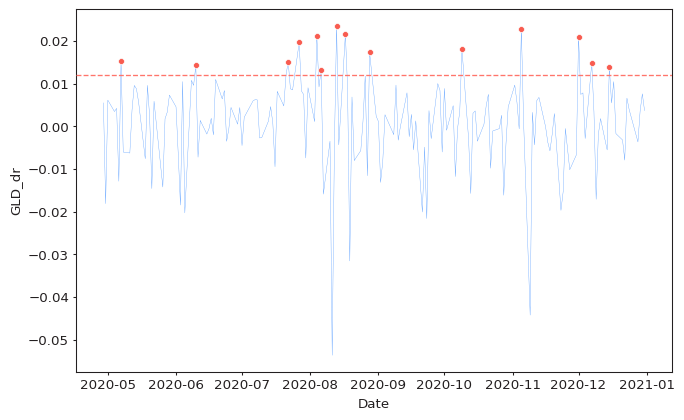

In [28]:
from pyextremes import get_extremes
from pyextremes.plotting import plot_extremes
GLD_extremes_high = get_extremes(data['GLD_dr'], "POT", threshold=get_threshold_range(data['GLD_dr'])[0], r="24H")
plot_extremes(
    ts=data['GLD_dr'],
    extremes=GLD_extremes_high,
    extremes_method="POT",
    extremes_type="high",
    threshold=get_threshold_range(data['GLD_dr'])[0],
)
GLD_extremes_high

Lower extremes

Date
2020-08-11   -0.053694
2020-11-09   -0.044271
Name: GLD_dr, dtype: float64

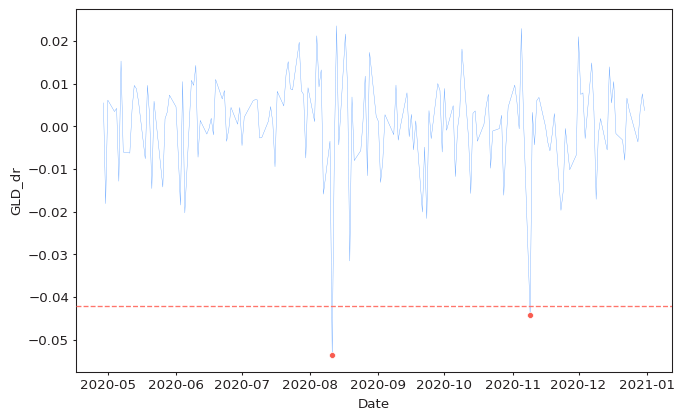

In [29]:
GLD_extremes_low = get_extremes(data['GLD_dr'], "POT", threshold=get_threshold_range(data['GLD_dr'])[1], extremes_type = "low", r="24H")
plot_extremes(
    ts=data['GLD_dr'],
    extremes=GLD_extremes_low,
    extremes_method="POT",
    extremes_type="low",
    threshold=get_threshold_range(data['GLD_dr'])[1],
)
GLD_extremes_low

##### EEM Extreme Values

Date
2020-04-29    0.029145
2020-05-18    0.039134
2020-07-06    0.043037
2020-11-04    0.031442
Name: EEM_dr, dtype: float64

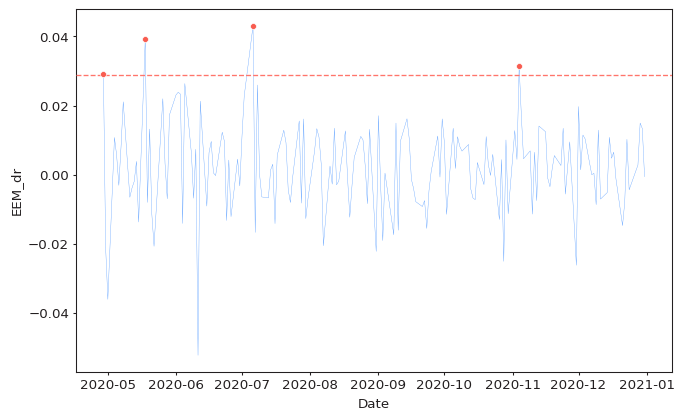

In [30]:
EEM_extremes_high = get_extremes(data['EEM_dr'], "POT", threshold=get_threshold_range(data['EEM_dr'])[0], r="24H")
plot_extremes(
    ts=data['EEM_dr'],
    extremes=EEM_extremes_high,
    extremes_method="POT",
    extremes_type="high",
    threshold=get_threshold_range(data['EEM_dr'])[0],
)
EEM_extremes_high

Date
2020-06-11   -0.052197
Name: EEM_dr, dtype: float64

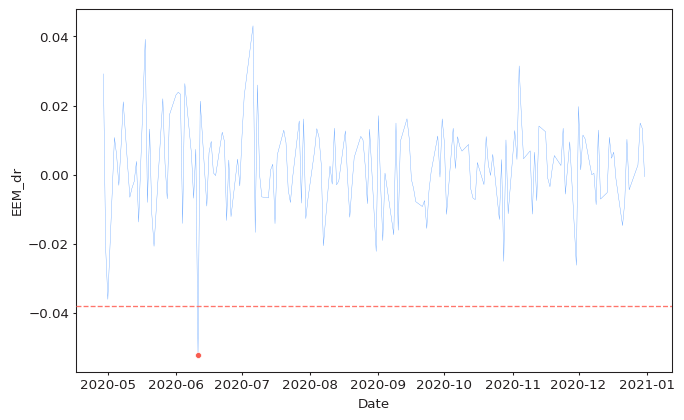

In [31]:
EEM_extremes_low = get_extremes(data['EEM_dr'], "POT", threshold=get_threshold_range(data['EEM_dr'])[1], extremes_type = "low", r="24H")
plot_extremes(
    ts=data['EEM_dr'],
    extremes=EEM_extremes_low,
    extremes_method="POT",
    extremes_type="low",
    threshold=get_threshold_range(data['EEM_dr'])[1],
)
EEM_extremes_low

GBTC Extreme Values

Date
2020-11-30    0.231431
Name: GBTC_dr, dtype: float64

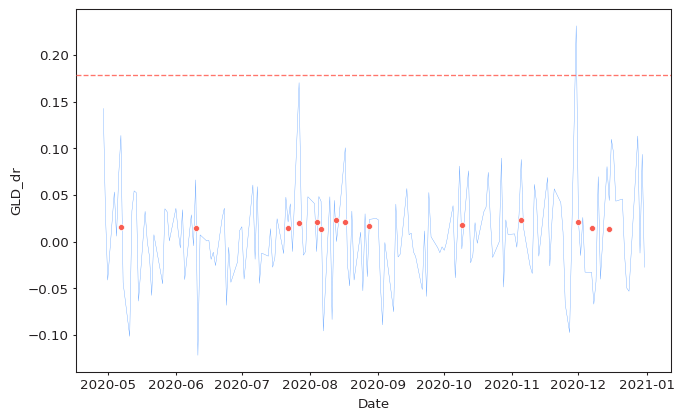

In [32]:
GBTC_extremes_high = get_extremes(data['GBTC_dr'], "POT", threshold=get_threshold_range(data['GBTC_dr'])[0], r="24H")
plot_extremes(
    ts=data['GBTC_dr'],
    extremes=GLD_extremes_high,
    extremes_method="POT",
    extremes_type="high",
    threshold=get_threshold_range(data['GBTC_dr'])[0],
)
GBTC_extremes_high

Date
2020-05-11   -0.101310
2020-06-11   -0.121594
2020-08-07   -0.095568
2020-08-11   -0.083272
2020-09-03   -0.089049
2020-09-08   -0.074938
2020-11-27   -0.097292
Name: GBTC_dr, dtype: float64

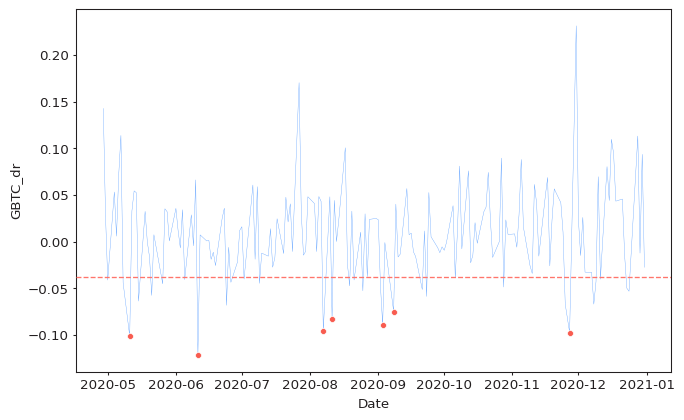

In [33]:
GBTC_extremes_low = get_extremes(data['GBTC_dr'], "POT", threshold=get_threshold_range(data['GBTC_dr'])[1], extremes_type = "low", r="24H")
plot_extremes(
    ts=data['GBTC_dr'],
    extremes=GBTC_extremes_low,
    extremes_method="POT",
    extremes_type="low",
    threshold=get_threshold_range(data['EEM_dr'])[1],
)
GBTC_extremes_low

### Step 4: Data Comparision: Copula


Compare the number of extreme values in each series

In [34]:
print("GLD extreme values count is " + str(len(GLD_extremes_high)+ len(GLD_extremes_low)))
print("EEM extreme values count is " + str(len(EEM_extremes_high)+ len(EEM_extremes_low)))
print("GBTC extreme values count is " + str(len(GBTC_extremes_high)+ len(GBTC_extremes_low)))

GLD extreme values count is 16
EEM extreme values count is 5
GBTC extreme values count is 8


Since GLD and GBTC are the two series with higher extreme value count, we plot them against each other as follow

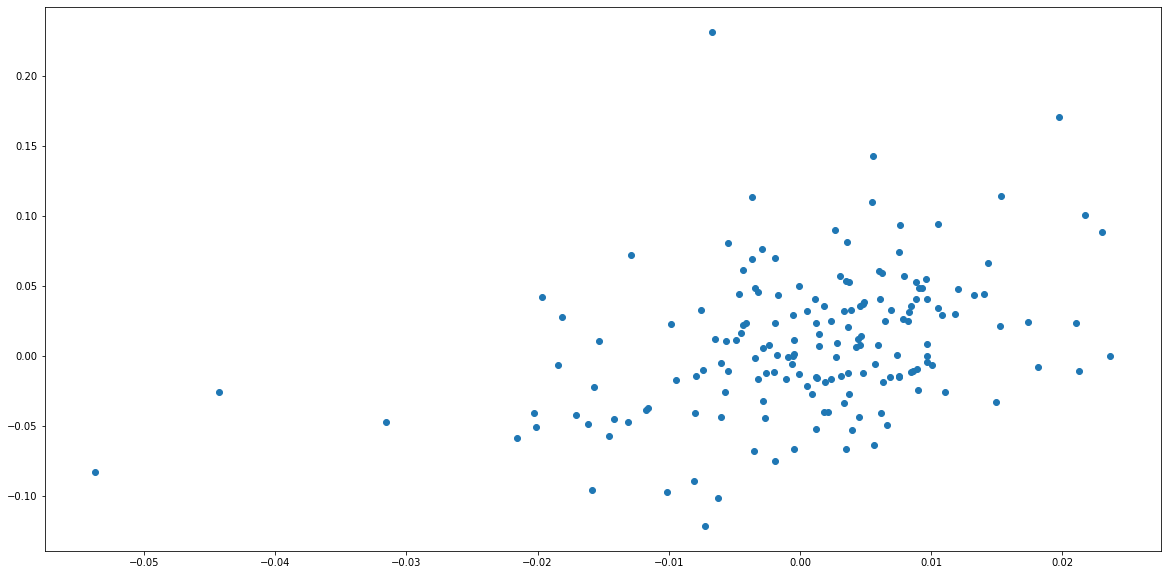

In [35]:
plt.scatter(data['GLD_dr'], data['GBTC_dr'])

We then fit the Clayton copula to the 2 series returns in the following section

In [36]:
!pip install copulae

     |████████████████████████████████| 2.3 MB 5.0 MB/s 
     |████████████████████████████████| 38.1 MB 1.1 MB/s 
     |████████████████████████████████| 9.8 MB 35.1 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [39]:
from copulae.archimedean import ClaytonCopula
cc = ClaytonCopula(dim = 2)
cc.fit(data[['GLD_dr','GBTC_dr']])
cc.summary()

          GLD_dr     GBTC_dr
count  172.00000  172.000000
mean     0.50000    0.500000
std      0.28784    0.287839
min      0.00578    0.005780
25%      0.25289    0.252890
50%      0.50000    0.500000
75%      0.74711    0.747110
max      0.99422    0.994220


Clayton Copula Summary
================================================================================
Clayton Copula with 2 dimensions


Parameters
--------------------------------------------------------------------------------
       theta        : 0.5934885170157524

In [40]:
cc.log_lik(data[['GLD_dr','GBTC_dr']])

14.879658111173384

The low log likelihood value implies the fitted model of Clayton Copula with theta parameter ~ 0.59 did not fit the data very well

### Step 5: Category 1 model for GBTC

In [41]:
!pip install backtesting

     |████████████████████████████████| 175 kB 5.3 MB/s 
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173822 sha256=e0508db743a7427420955c160a9f1c7d2948b689de5c43a15d280275f8c3a6b1
  Stored in directory: /root/.cache/pip/wheels/48/1d/ea/65dacebc37da7655d8a1fd0f315ac39d102e31d6545237a1c6
Successfully built backtesting


In this section, we conduct ARMA/ GARCH based strategy for GBTC data

#### 1st strategy: ARMA-based

Our ARMA strategy is described as follow

*   Forecasting Q3 daily return using Q2 as training data using ARMA
*   If the predicted price for today is lower than actual price, we short GBTC with our entire portfolio
*   If the predicted price for today is higher than actual price, we exit previous position and long GBTC/ vice-versa




In [42]:
!pip install arch

     |████████████████████████████████| 902 kB 5.1 MB/s 


In [43]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.4 MB/s 


In [50]:
data_q2 = data[Apr20:Jul20]
data_q3 = data[Jul20:Oct20]
data_q4 = data[Oct20:Jan21]

In [44]:
#estimating stationary/ order of integration
from pmdarima.arima.utils import ndiffs
ndiffs(data_q2['GBTC'], test='adf')

1

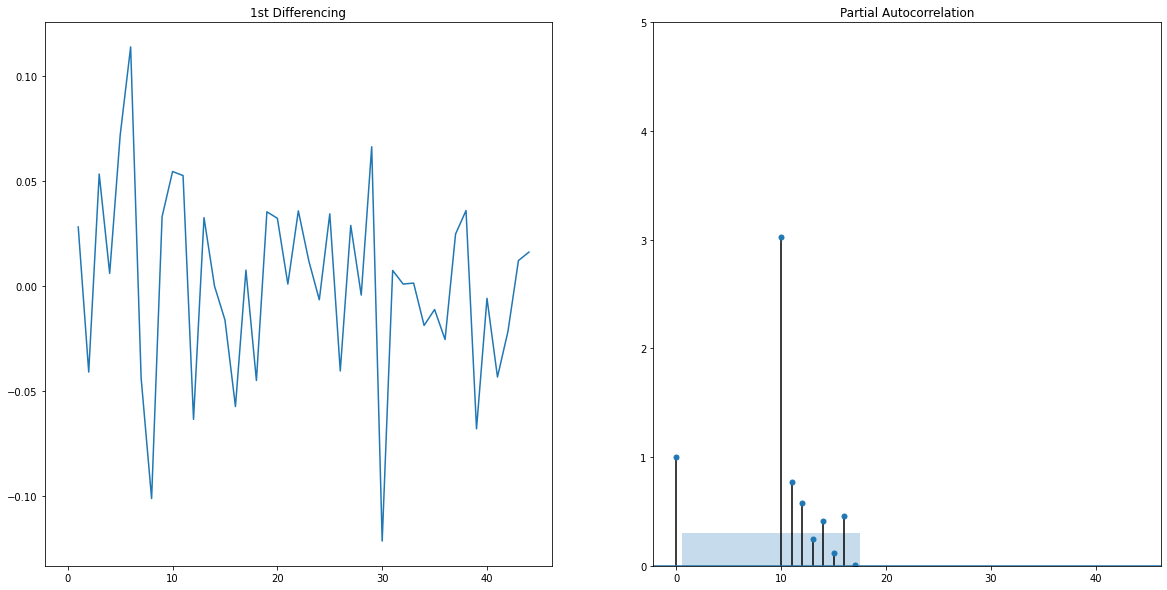

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df = pd.DataFrame(data_q2['GBTC_dr']).reset_index(drop=True)
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.diff().dropna(), ax=axes[1])

plt.show()

Based on the ACF plot, we choose 1 as the order of the AR term

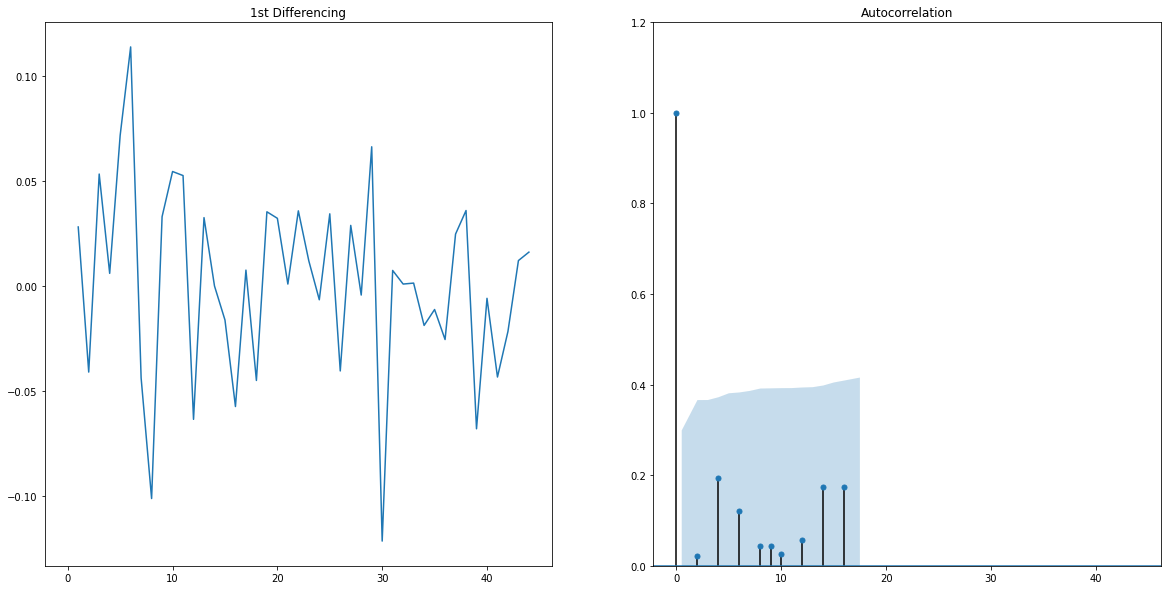

In [52]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.diff().dropna(), ax=axes[1])

plt.show()

Based on the correlation plot, we choose 1 as the MA term

In [55]:
# Forecasting
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df.dropna(), order=(0,1,1))
model_fit = model.fit(disp=0)
data_q3['GBTC_pp'] = model_fit.forecast(len(data_q3))[0]

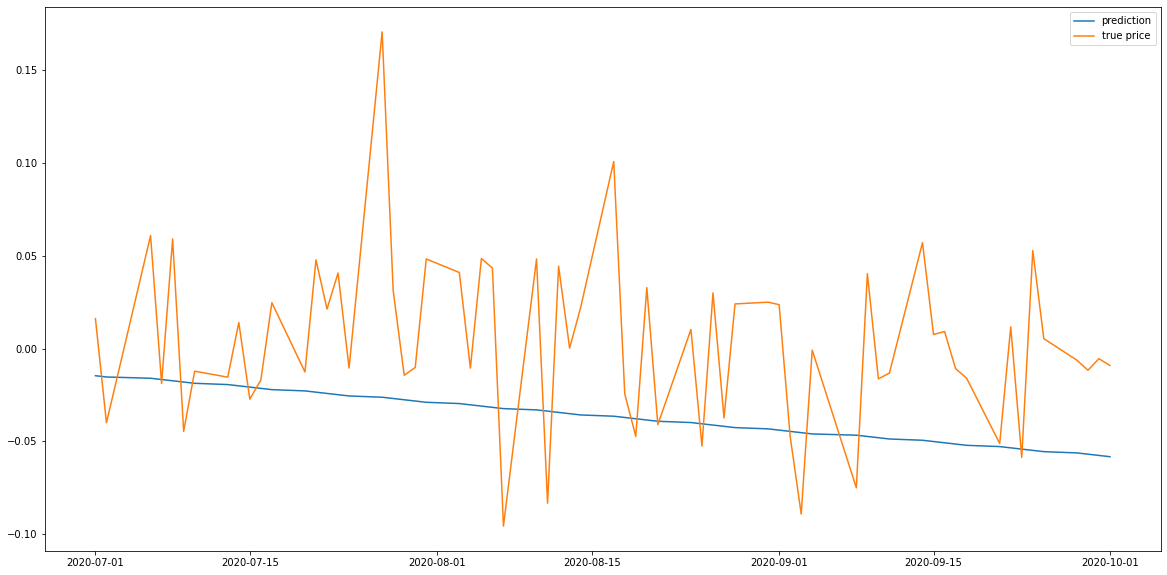

In [56]:
plt.plot(data_q3['GBTC_pp'], label = 'prediction')
plt.plot(data_q3['GBTC_dr'], label = 'true price')
plt.legend()

In [57]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover, SignalStrategy
class ARMAS(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(data_q3['GBTC_dr'] < data_q3['GBTC_pp'], data_q3['GBTC_dr'] > data_q3['GBTC_pp'])
bt = Backtest(GBTC[Jul20:Oct20], ARMAS, exclusive_orders=True)
stats = bt.run()
bt.plot()

Row(id='1525', ...)